# Fisherova-Kolmogorovova rovnice s radiálně symetrickou počáteční podmínkou


Fisherova-Kolmogorovova rovnice ve 2D pro neznámou funkci $u(x,y,t)$ má následující tvar

$$u_t = \Delta{u} + u(1-u)$$ 

Pokud uvažujeme vzhledem k počátku radiálně symetrickou počáteční podmínku, lze pomocí transformace do polárních souřadnic $u(x,y) \longrightarrow u(r,\rho), x=r\cos{\rho}, y=r\sin{\rho}$ přepsat rovnici do tvaru

$$u_t = u_{rr} + \frac{1}{r}u_r + u(1-u).$$

Tuto rovnici neumíme převést na ODR s pomocí proměnné $z=r-ct$ stejně jako v případě 1D rovnice, můžeme ale přesto pomocí analýzy jejího chování dojít k zajímavým výsledkům.

Oproti 1D rovnici nám přibyl advekční člen $\frac{1}{r}u_r$, který v závislosti na velikosti $r$ mění rychlost vlny. Pro $r\rightarrow \infty$ je advekční člen zanedbatelný a platí tedy $u_t \approx u_{rr} + u(1-u)$. Pro velká $r$ se proto rychlost vlny blíží $c\approx 2$. Difuzní člen $u_{rr}$ vznikající vlnu radiálně symetricky roztahuje do stran, člen $u(1-u)$ zajistí pro $u<1$ logistický růst k $u=1$. Pro počáteční $u>1$ bude naopak u klesat k 1.

Z tohoto je tedy vidět, že rychlost vlny $c$ je závislá na poloměru $r$ a není konstatní jako v 1D případě. 

## Numerické experimenty s různými počátečními podmínkami

Rovnici řešíme numericky ve formě $u_t = \Delta{u} + u(1-u)$ pro různé počáteční podmínky.

Rychlost vlny $c$ se pokusíme odhadnout z numerického řešení. Ve vybraných časových krocích $t_i$ získáme hodnotu $r_i = u_i^{-1}(k)$, kde $k$ je daná konstanta.  Poslouopnost $r_i$ deifnuje funkci růstu poloměru vlny. Stačí ji tedy derivovat a získame tak rychlost vlny $c$.


In [230]:
import pde
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

plt.rcParams['figure.figsize'] = [10, 10]
plt.style.use("ggplot")
plt.rcParams.update({'font.size': 12})

# funkce řešení úlohy

def fksolve(domain_size=100.,
           grid_size = 1000,
           max_time = 9,   # 10 steps, as count starting 0
           dt = 0.001,
           tracker_int = 0.05,
           iv_size = 200,
           iv_func = lambda x, y: 1,
           slice_num = 10,
           ylim = 1.1,
           u_level = 0.2):   # u value to approximate the speed at

    fig = plt.figure(figsize=(20,18))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)

    # grid 
    grid = pde.CartesianGrid([[0, domain_size]]*2, grid_size)
    
    # axisymmetric initial values
    X = np.linspace(-1.,1.,iv_size)
    Y = np.linspace(-1.,1.,iv_size)
    Z = np.zeros((iv_size,iv_size))
    for i in range(0,iv_size): 
        for j in range(0,iv_size):
            if X[i]**2+Y[j]**2<1:
                Z[i,j] = iv_func(X[i],Y[j])
    x0 = np.zeros(grid.shape)
    lo = int((grid_size - iv_size)/2)
    hi = lo+iv_size
    x0[lo:hi, lo:hi] = Z

    state = pde.ScalarField(grid,x0) #.smooth()
    state.plot(cmap='Blues', clim=(0,1), ax=ax1, title='Počáteční podmínka')
    
    # solve the problem
    eq = pde.PDE(
        {"u": "laplace(u) + u*(1-u)"},
    )
    storage = pde.MemoryStorage()
    tracker = ['progress', storage.tracker(interval=tracker_int)] 
    result = eq.solve(state, t_range=max_time, dt=dt, tracker=tracker)
    
    
    # plot results

    ### !!!!!! kreslit z storage.times
    t_size = len(storage.data)-1
    ts = np.linspace(0, t_size, slice_num, dtype=np.int32)
    
    X = np.linspace(0, domain_size, grid_size)#x_size)
    
    cmap = plt.get_cmap('Blues')
    colors = cmap(np.linspace(.4, 1.0, slice_num))    
    for t, color in zip(ts, colors):
        ax3.plot(X,storage.data[t][int(grid_size/2)], color=color, label='t={:.2f}'.format(t*tracker_int))

    ax3.set_xlabel('y')
    ax3.set_ylabel('u({:.2f},y,t)'.format(domain_size/2))
    ax3.set_title('Řezy řešení u(x,y,t) v x={:.2f}'.format(domain_size/2))
    ax3.set_xlim([0,domain_size])
    ax3.set_ylim([0,ylim])   
    ax3.legend()
    
    result.plot(cmap='Blues', clim=(0,1), ax=ax2, title='Řešení u(x,y,t) v čase t={}'.format(max_time))
    
    # c(r) speed
    #ts = np.linspace(0, len(storage.data)-1, slice_num)
    #ts = ts.astype(int)
    ts = storage.times
    t_size = len(ts)
    rs = np.linspace(*grid.axes_bounds[0], grid.shape[0])
    
    half_grid_size = int(grid_size/2)

    r_t = np.zeros(t_size)
    
    for t in range(t_size):
        #r_data = storage.data[ts[t]][half_grid_size]
        r_data = storage.data[t][half_grid_size]
        #r_t[t] = np.argwhere(r_data>u_level)[-1][0] * (domain_size/grid_size)
        #r_t[t] = rs[np.argwhere(r_data>=u_level)[-1]]
        rs_inx = np.argwhere(r_data>=u_level)
        r_t[t] = rs[rs_inx[-1]] + (rs[rs_inx[-1]+1] - rs[rs_inx[-1]]) * ((u_level - r_data[rs_inx[-1]+1])/(r_data[rs_inx[-1]] - r_data[rs_inx[-1]+1])) 
        
    x = np.linspace(0, max_time, len(r_t))
    ax4.plot(ts, np.gradient(r_t)/(max_time/t_size), 'bx:')
    ax4.set_xlabel('t')
    ax4.set_ylabel('c(x,y,t)')
    ax4.set_title('Numerická rychlost pravé části vlny v u(x,y,t)={}'.format(u_level))

    plt.show()

    return result, storage, grid




def plt_res(storage, grid, max_time, u_level, slice_num):

    
    fig = plt.figure(figsize=(20,18))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    
    grid_size = grid.shape[0]
#    u_level = .2
#    max_time = 25

#   ts = np.linspace(0, len(storage.data)-1, slice_num)
    ts = np.array(storage.times)
    t_size = len(ts)
    rs = np.linspace(*grid.axes_bounds[0], grid.shape[0])

    half_grid_size = int(grid_size/2)

    r_t = np.zeros(t_size)

    for t in range(t_size):
        r_data = storage.data[t][half_grid_size]
        #r_t[t] = np.argwhere(r_data>u_level)[-1][0] * (domain_size/grid_size)
        #r_t[t] = rs[np.argwhere(r_data>=u_level)[-1]]
        rs_inx = np.argwhere(r_data>=u_level)
        r_t[t] = rs[rs_inx[-1]] + (rs[rs_inx[-1]+1] - rs[rs_inx[-1]]) * ((u_level - r_data[rs_inx[-1]+1])/(r_data[rs_inx[-1]] - r_data[rs_inx[-1]+1])) 
        #r_t[t] = rs[np.argwhere(r_data>=u_level)[-1]]
    #x = np.linspace(0, max_time, len(r_t))

    #r_der = np.gradient(r_t/(max_time/t_size))
    r_der = (r_t[1:]-r_t[:-1]) / (ts[1:]-ts[:-1])
    ax1.plot(ts[:-1], r_der, 'bx:')
    ax1.set_xlabel('t')
    ax1.set_ylabel('c(x,y,t)')
    ax1.set_title('Dopředná dif - všechny body'.format(u_level))
    
    r_der = (r_t[10:]-r_t[:-10]) / (ts[10:]-ts[:-10])
    ax2.plot(ts[:-10], r_der, 'bx:')
    ax2.set_xlabel('t')
    ax2.set_ylabel('c(x,y,t)')
    ax2.set_title('Dopředná dif - ob 10'.format(u_level))


    ax3.plot(ts, np.gradient(r_t, ts), 'gx:')
    ax3.set_title('numpy derivace - všechny body')

    
    
    xty = int(len(storage.times) / (slice_num-1))
    #ts = np.linspace(0, t_size, slice_num, dtype=np.int32)
    #xty = 30
    print(ts[0::xty])
    print(r_t[0::xty])
    print(np.gradient(r_t[0::xty], ts[0::xty]))
    ax4.plot(ts[0::xty], np.gradient(r_t[0::xty], ts[0::xty]), 'gx:')
    ax4.set_title('numpy derivace - každý {}-tý ({} řezů)'.format(xty, slice_num))
    
    plt.show()
    #plt.plot(x, r_t, 'rx:')
    #print(r_t)


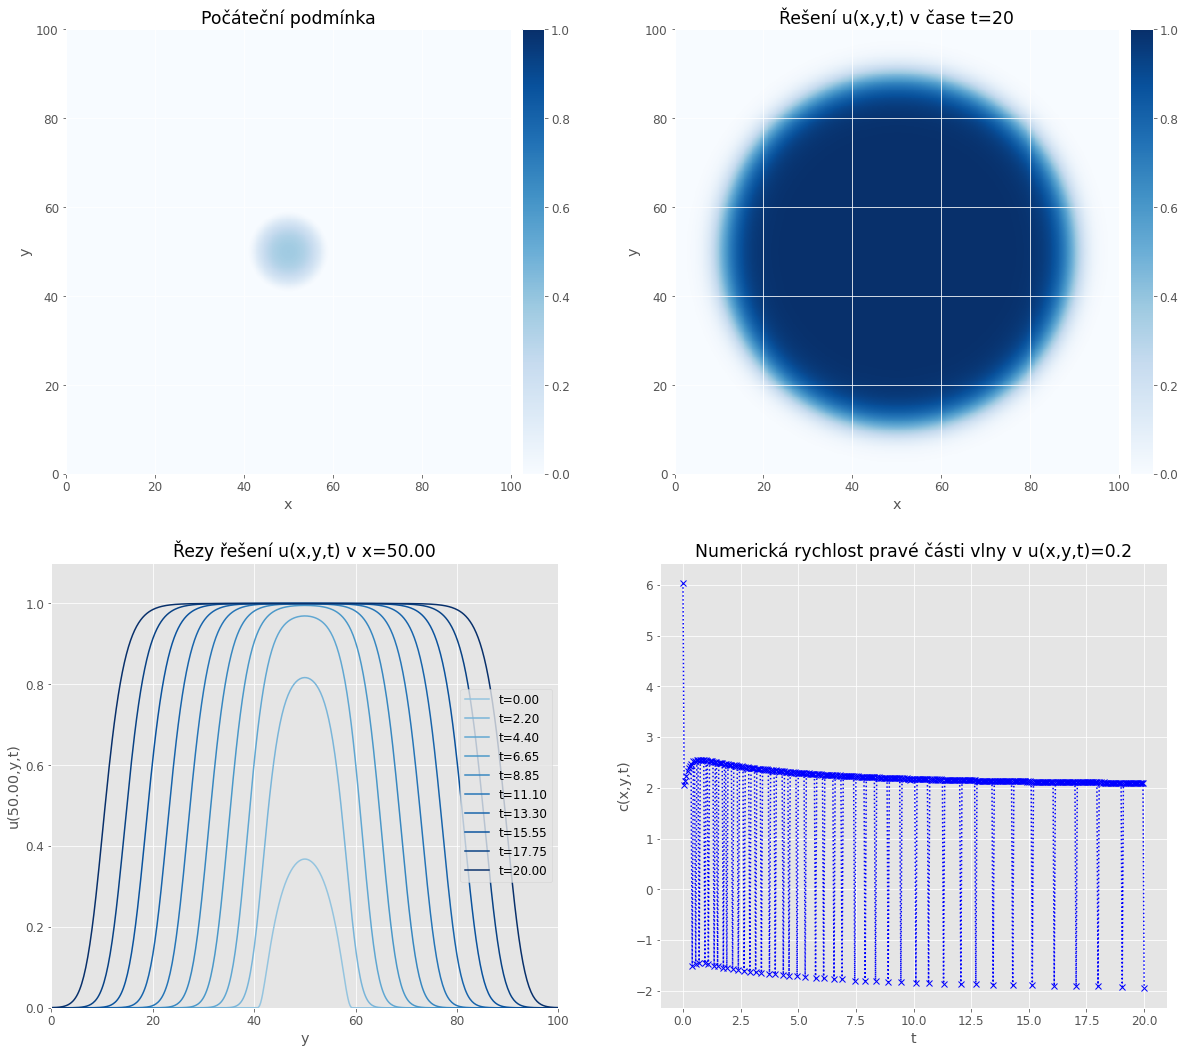

In [220]:
result, storage, grid = fksolve(max_time = 20, 
                                iv_size = 100,
                                iv_func = lambda x,y: np.exp(-1/(1-x**2-y**2)),
                                dt = .001,
                                domain_size = 100,
                                grid_size = 500,
                                tracker_int = .05,
                               )

[ 0.     2.201  4.4    6.6    8.8   11.001 13.201 15.401 17.601 19.801]
[55.9208295  59.33758503 62.9496415  66.75215771 70.82114464 74.80026289
 79.11956664 82.99277028 87.23178455 91.44457813]
[6.01566782 2.43766006 2.27680783 2.24156704 2.19595462 2.16024594
 2.13266941 2.11714405 2.10430421 2.09347277]


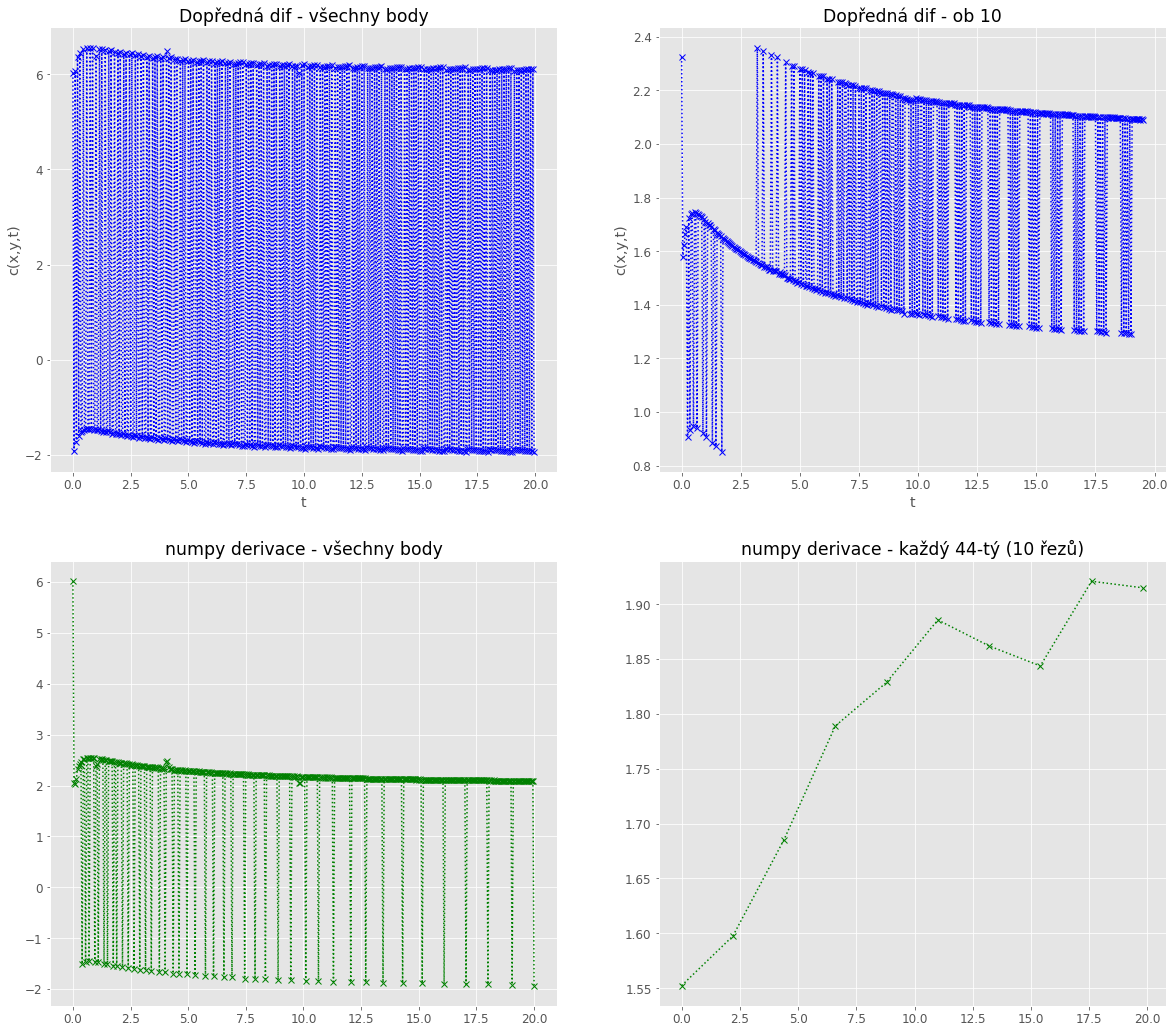

In [224]:
plt_res(storage, grid, 40, .2, 10)

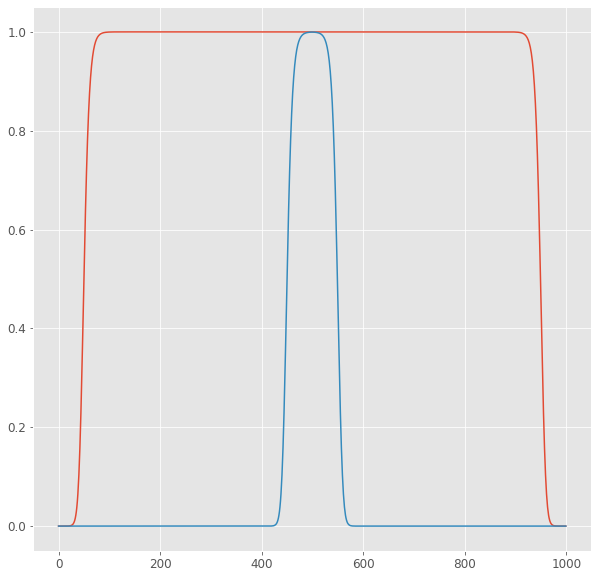

In [124]:
plt.plot(storage.data[-1][400])

ivss = np.concatenate((storage.data[-1][400][0:100], storage.data[-1][400][900:1000]))
iv = np.zeros(1000)
iv[400:600] = ivss
plt.plot(iv)

In [56]:
len(storage.data)

501

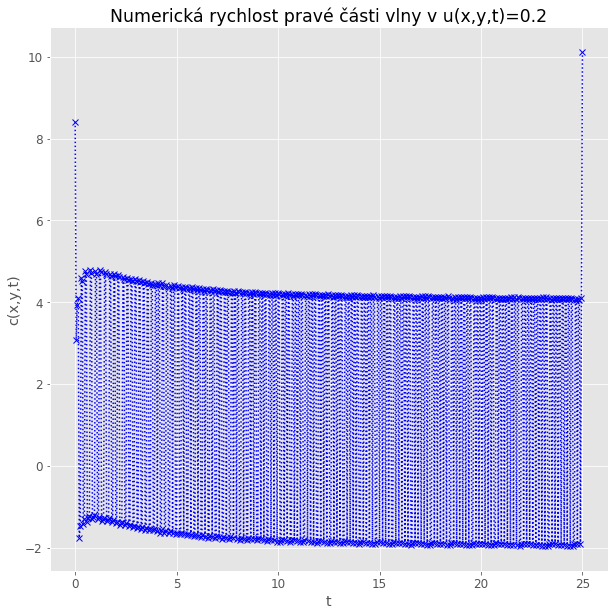

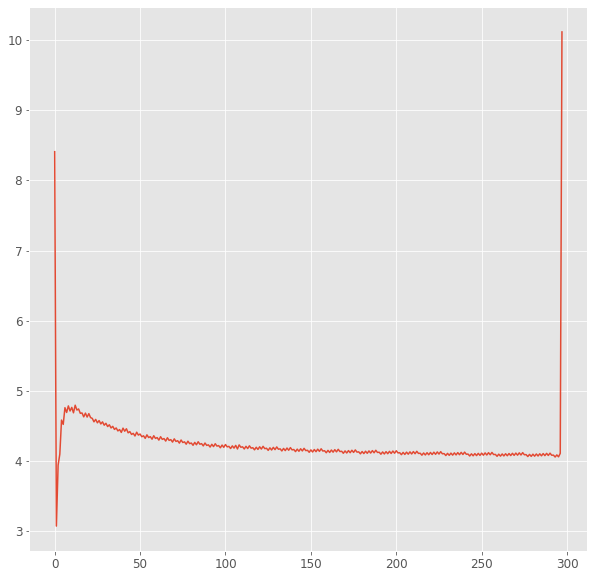

[ 80.62124248  81.04087514  80.92796337  81.43428293  81.33696301
  81.2587434   81.1902553   81.71625207  81.64163667  81.57447294
  81.51081257  82.04959368  81.97913911  81.91361008  81.8515804
  81.79205677  82.32923809  82.26248726  82.19886367  82.13761368
  82.07932958  82.61316476  82.547182    82.48358864  82.42187274
  82.96227305  82.89365853  82.82750608  82.76334556  82.70078154
  83.23665868  83.16793727  83.10132683  83.03644759  82.97297086
  83.50404837  83.43508514  83.36797658  83.30239936  83.83537407
  83.76421389  83.69501712  83.62746444  84.16169034  84.08852174
  84.01740905  83.94803626  83.88011947  84.4079643   84.33512382
  84.2641021   84.19461624  84.72259885  84.64822448  84.57573116
  84.50483724  85.03255308  84.95683765  84.88304966  84.81090906
  85.33800263  85.26113326  85.18622269  85.11299275  85.63915478
  85.56130975  85.48544073  85.41127183  85.93623628  85.85758293
  85.78090964  85.70594312  86.22948432  86.15017771  86.07284304
  85.997209

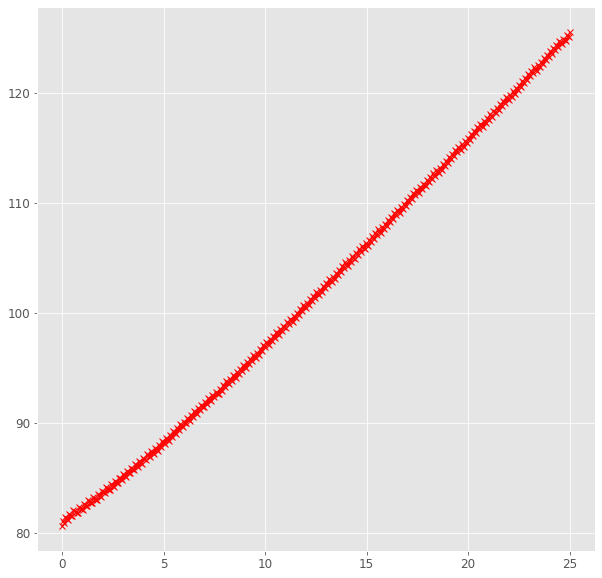

In [57]:



# c(r) speed
slice_num =100
grid_size = 500
u_level = .2
max_time = 25

ts = np.linspace(0, len(storage.data)-1, slice_num)
ts = np.arange(len(storage.data))
ts = ts.astype(int)
t_size = len(ts)
rs = np.linspace(*grid.axes_bounds[0], grid.shape[0])

half_grid_size = int(grid_size/2)

r_t = np.zeros(t_size)

for t in range(t_size):
    r_data = storage.data[ts[t]][half_grid_size]
    rs_inx = np.argwhere(r_data>=u_level)
    r_t[t] = rs[rs_inx[-1]] + (rs[rs_inx[-1]+1] - rs[rs_inx[-1]]) * ((u_level - r_data[rs_inx[-1]+1])/(r_data[rs_inx[-1]] - r_data[rs_inx[-1]+1])) 
    #r_t[t] = rs[np.argwhere(r_data>=u_level)[-1]]
x = np.linspace(0, max_time, len(r_t))

r_der = np.gradient(r_t/(max_time/t_size))
plt.plot(x, r_der, 'bx:')
plt.xlabel('t')
plt.ylabel('c(x,y,t)')
plt.title('Numerická rychlost pravé části vlny v u(x,y,t)={}'.format(u_level))

plt.show()

plt.plot(r_der[r_der>1.5])
plt.show()
plt.plot(x, r_t, 'rx:')
print(r_t)

In [41]:
print(len(r_t))
uuu = np.gradient(r_t/(max_time/t_size))
vvv = uuu[uuu>=2]
print(len(vvv))
vvv

395
310


array([2.0168596 , 2.12625522, 2.23835029, 2.33116614, 2.39234538,
       2.49441798, 2.51406968, 2.54651619, 2.55017971, 2.55072   ,
       2.54163849, 2.52434836, 2.5250151 , 2.52246592, 2.50687737,
       2.50459254, 2.48868817, 2.48670073, 2.47098974, 2.46925178,
       2.46777956, 2.45240007, 2.45106688, 2.43618461, 2.43494739,
       2.43387091, 2.41942749, 2.41838616, 2.41746704, 2.40347469,
       2.40255272, 2.4017258 , 2.38819754, 2.3873452 , 2.38656852,
       2.37351843, 2.37270395, 2.37195109, 2.37125556, 2.35859659,
       2.35785145, 2.35715431, 2.34500742, 2.34426074, 2.34355507,
       2.34288803, 2.33117725, 2.33045991, 2.32977638, 2.32912486,
       2.32850369, 2.33413008, 2.31669687, 2.31605557, 2.31544018,
       2.30457727, 2.30391585, 2.30327809, 2.30266298, 2.30206957,
       2.29164115, 2.29100552, 2.29039004, 2.28979395, 2.28921652,
       2.27924356, 2.27862817, 2.27803033, 2.27744946, 2.27688497,
       2.26738134, 2.26678309, 2.26620041, 2.26563282, 2.26507

395
395


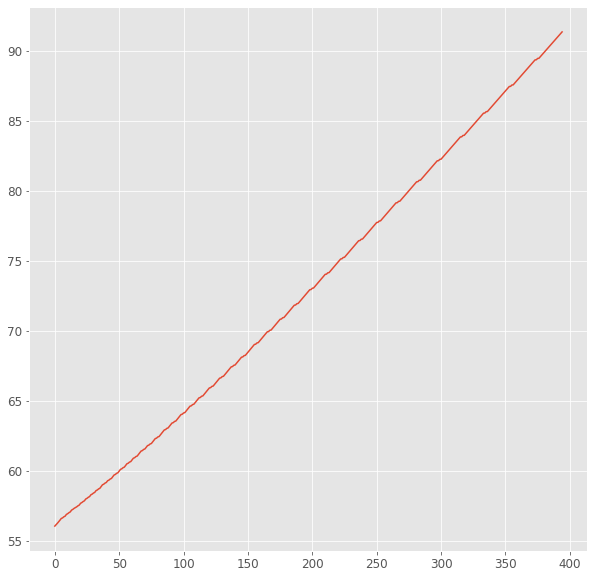

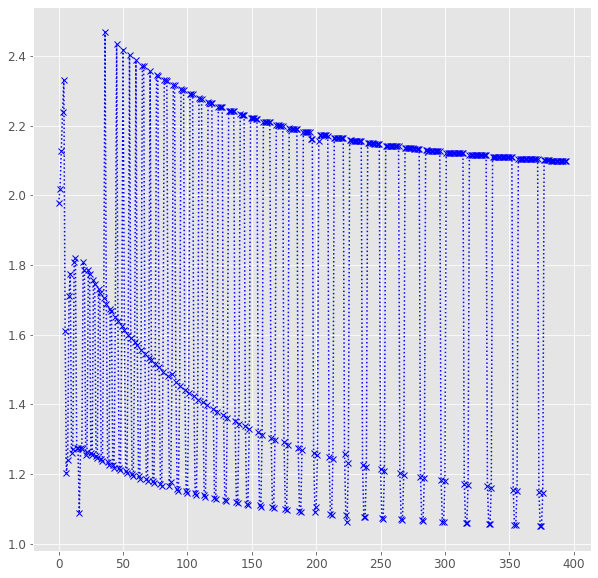

In [43]:
print(len(r_t))
print(len(np.unique(r_t)))
plt.plot(np.unique(r_t))
plt.show()
plt.plot(np.gradient(np.unique(r_t/(max_time/t_size))), 'b:x')


### Bump funkce

Základní počáteční podmínkou pro nás bude bump funkce $\Phi$, která je radiálně symetrická, je hladká $\Phi \in C^{\infty}$ a je funkcí s kompaktním supportem. Více viz třeba [Wikipedia](https://en.wikipedia.org/wiki/Bump_function).

Z následující simulace je patrný vliv logistického růstu, kdy profil řešení stoupá k 1 i vliv difuze, která vlnu roztahuje do stran. Díky převládajícímu růstu je rychlost vlny $c$ nejprve menší, později se ustálí a blíží se k hodnotě 2.

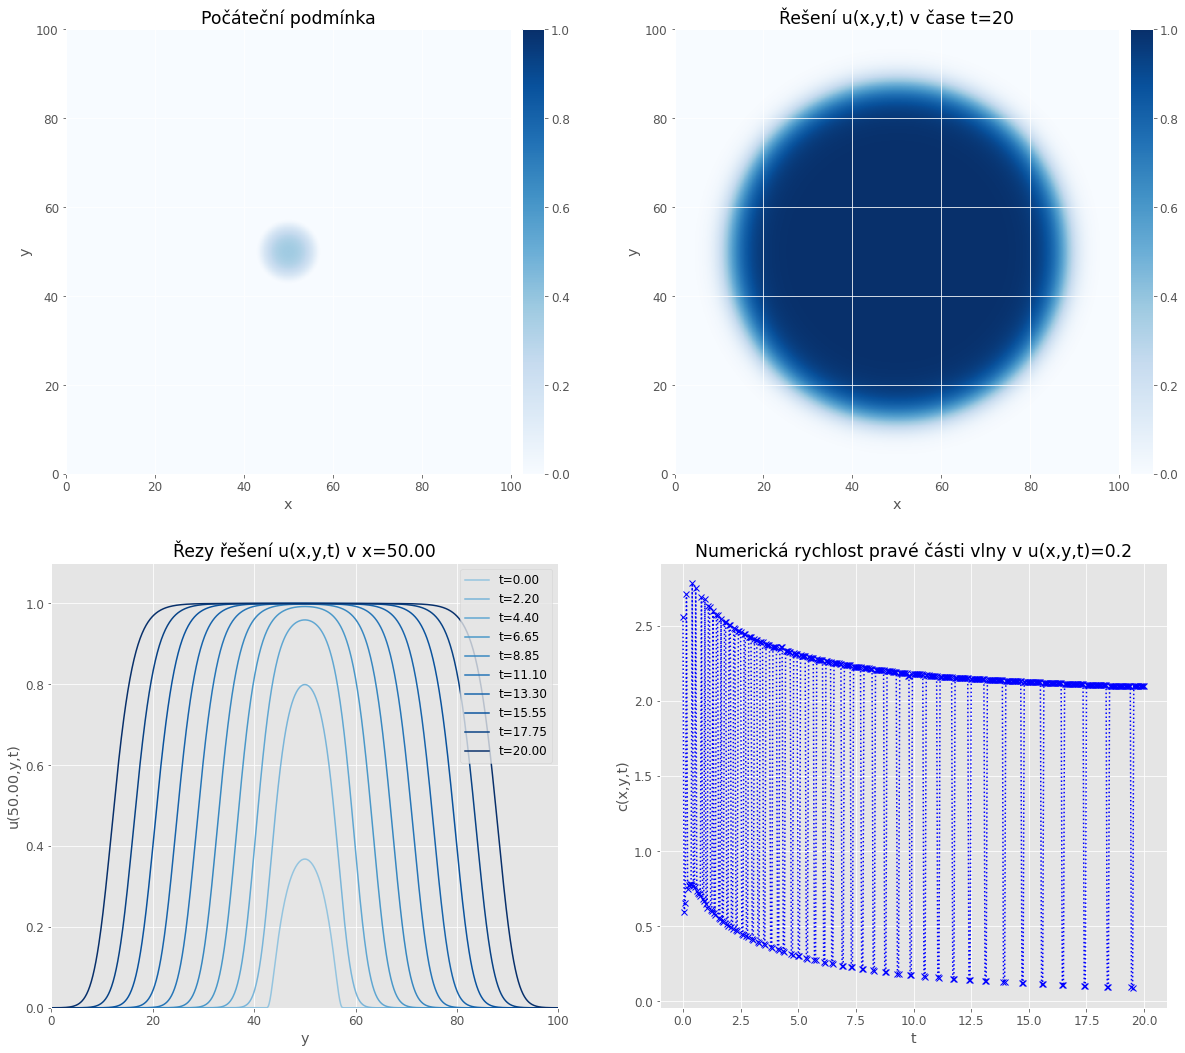

In [235]:
result, storage, grid = fksolve(max_time = 20, 
                                iv_func = lambda x,y: np.exp(-1/(1-x**2-y**2)),
                                dt = .001,
                                tracker_int=.05,
                                grid_size = 1000,
                                iv_size = 160,
                                domain_size=100
                               )

[ 0.     2.201  4.4    6.6    8.8   11.001 13.201 15.401 17.601 19.801]
[54.91344158 57.88820569 61.36237467 65.19042828 69.0734793  73.2603817
 77.18425884 81.4616283  85.50390614 89.71913442]
[1.35155116 1.4657704  1.65993691 1.75252378 1.83363239 1.84291317
 1.86391968 1.89082893 1.87670594 1.91601286]


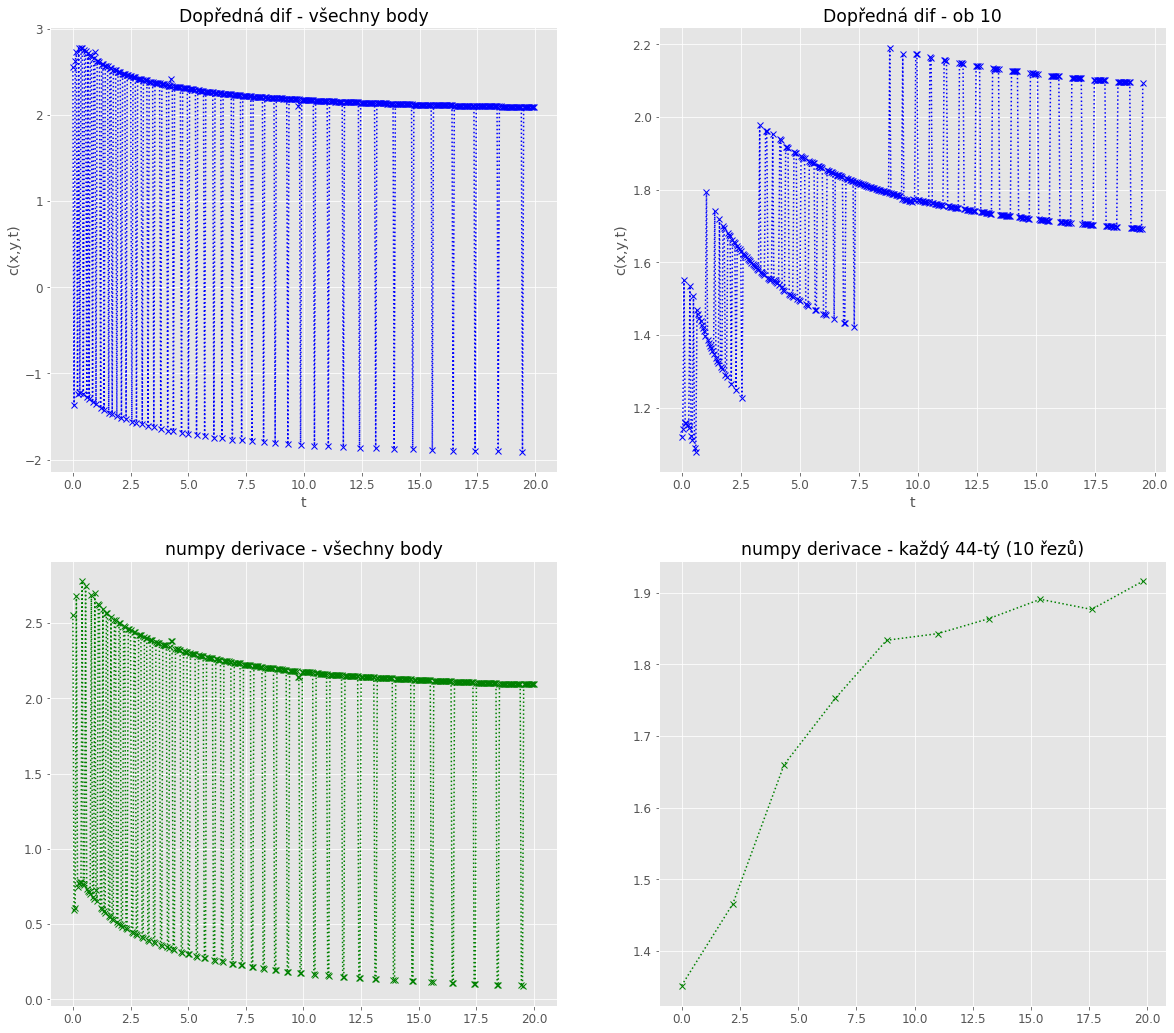

In [236]:
plt_res(storage, grid, 20, .2, 10)

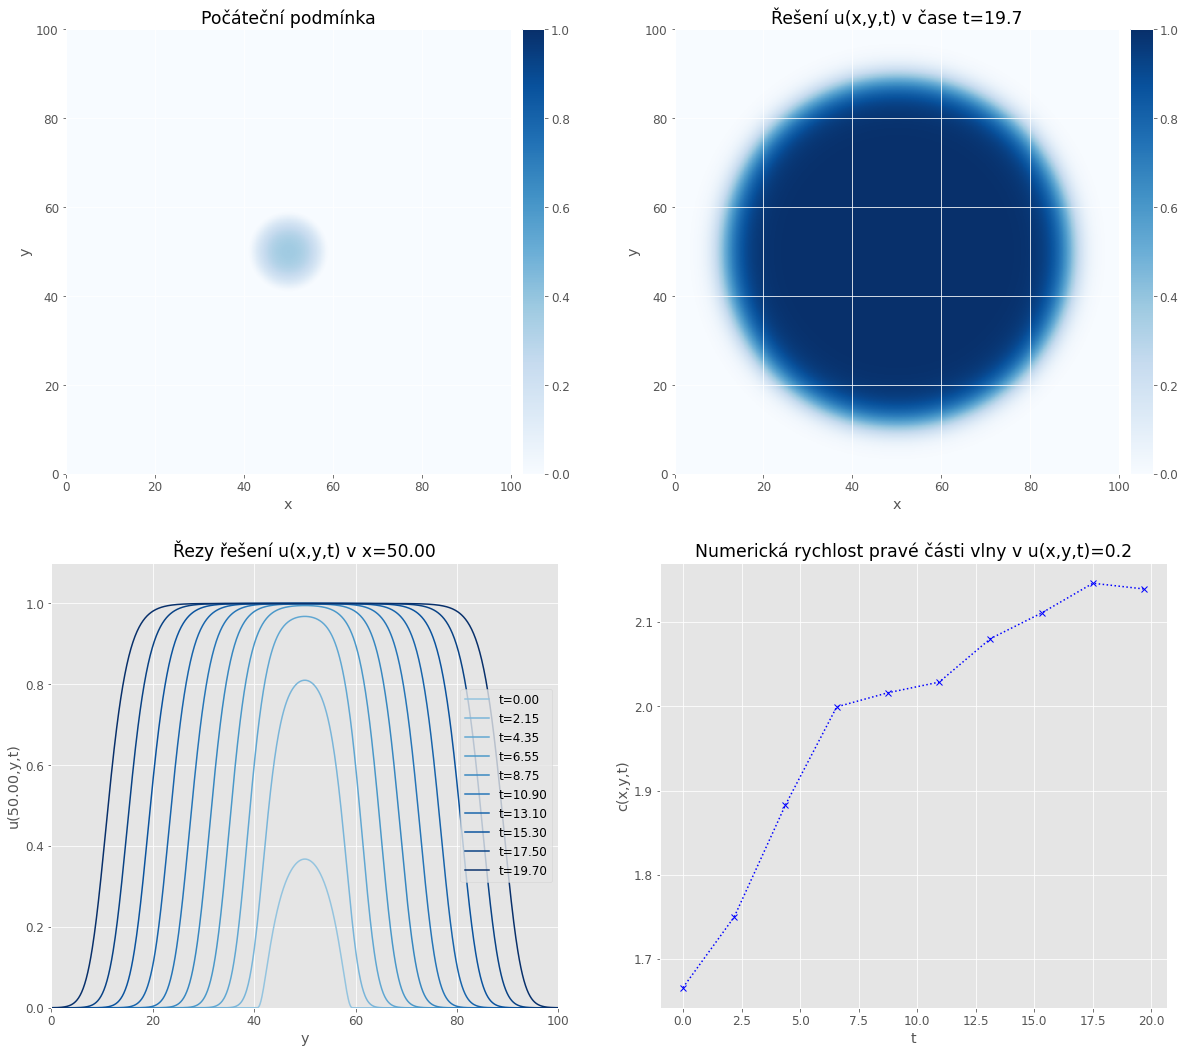

In [30]:
result, storage, grid = fksolve(max_time = 19.7, 
                                iv_func = lambda x,y: np.exp(-1/(1-x**2-y**2)),
                                dt = .001,
                                #grid_size = 1000
                               )

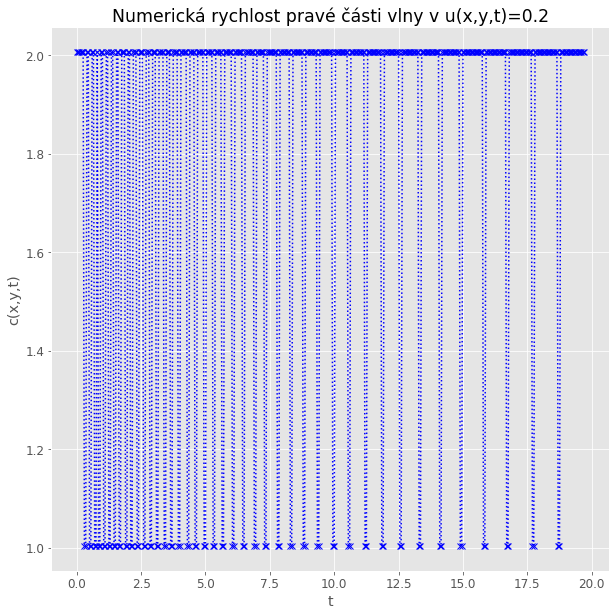

In [35]:
# c(r) speed
slice_num = 395
grid_size = 1000
u_level = .2
max_time = 19.7

ts = np.linspace(0, len(storage.data)-1, slice_num)
ts = ts.astype(int)
t_size = len(ts)
rs = np.linspace(*grid.axes_bounds[0], grid.shape[0])

half_grid_size = int(grid_size/2)

r_t = np.zeros(t_size)

for t in range(t_size):
    r_data = storage.data[ts[t]][half_grid_size]
    #r_t[t] = np.argwhere(r_data>u_level)[-1][0] * (domain_size/grid_size)
    r_t[t] = rs[np.argwhere(r_data>=u_level)[-1]]
x = np.linspace(0, max_time, len(r_t))


plt.plot(x, np.gradient(r_t)/(max_time/t_size), 'bx:')
plt.xlabel('t')
plt.ylabel('c(x,y,t)')
plt.title('Numerická rychlost pravé části vlny v u(x,y,t)={}'.format(u_level))

plt.show()

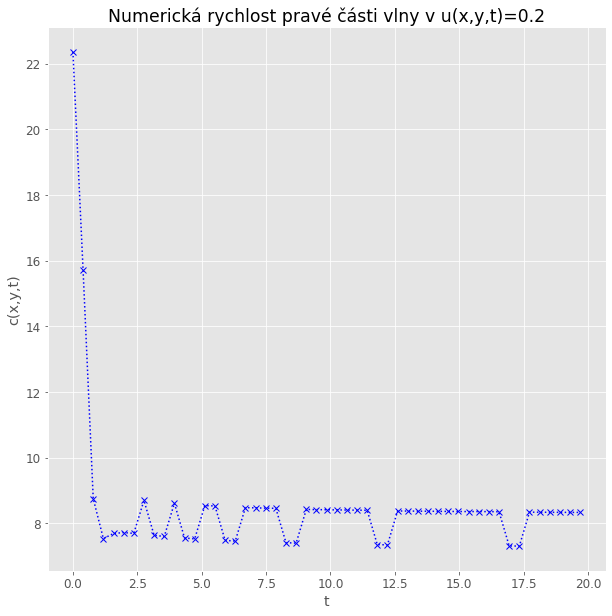

In [129]:



# c(r) speed
slice_num = 51
grid_size = 1000
u_level = .2
max_time = 19.7

ts = np.linspace(0, len(storage.data)-1, slice_num)
ts = ts.astype(int)
t_size = len(ts)
rs = np.linspace(*grid.axes_bounds[0], grid.shape[0])

half_grid_size = int(grid_size/2)

r_t = np.zeros(t_size)

for t in range(t_size):
    r_data = storage.data[ts[t]][half_grid_size]
    rs_inx = np.argwhere(r_data>=u_level)
    r_t[t] = rs[rs_inx[-1]] + (rs[rs_inx[-1]+1] - rs[rs_inx[-1]]) * ((u_level - r_data[rs_inx[-1]+1])/(r_data[rs_inx[-1]] - r_data[rs_inx[-1]+1])) 
x = np.linspace(0, max_time, len(r_t))


plt.plot(x, np.gradient(r_t)/(max_time/t_size), 'bx:')
plt.xlabel('t')
plt.ylabel('c(x,y,t)')
plt.title('Numerická rychlost pravé části vlny v u(x,y,t)={}'.format(u_level))

plt.show()

In [125]:
len(storage.data)

1601

### Bump funkce s maximem v $1$

Rozdíl oproti předchozímu případu je ve "velikosti" počáteční podmínky. Díky advekčnímu člunu nejprve hodnota funkce proto poklesne, ale velmi brzy začne díky logistickému růstu opět stoupat. Rychlost vllny se opět z počátečních menších hodnot přibližuje k hodnotě $2$. 

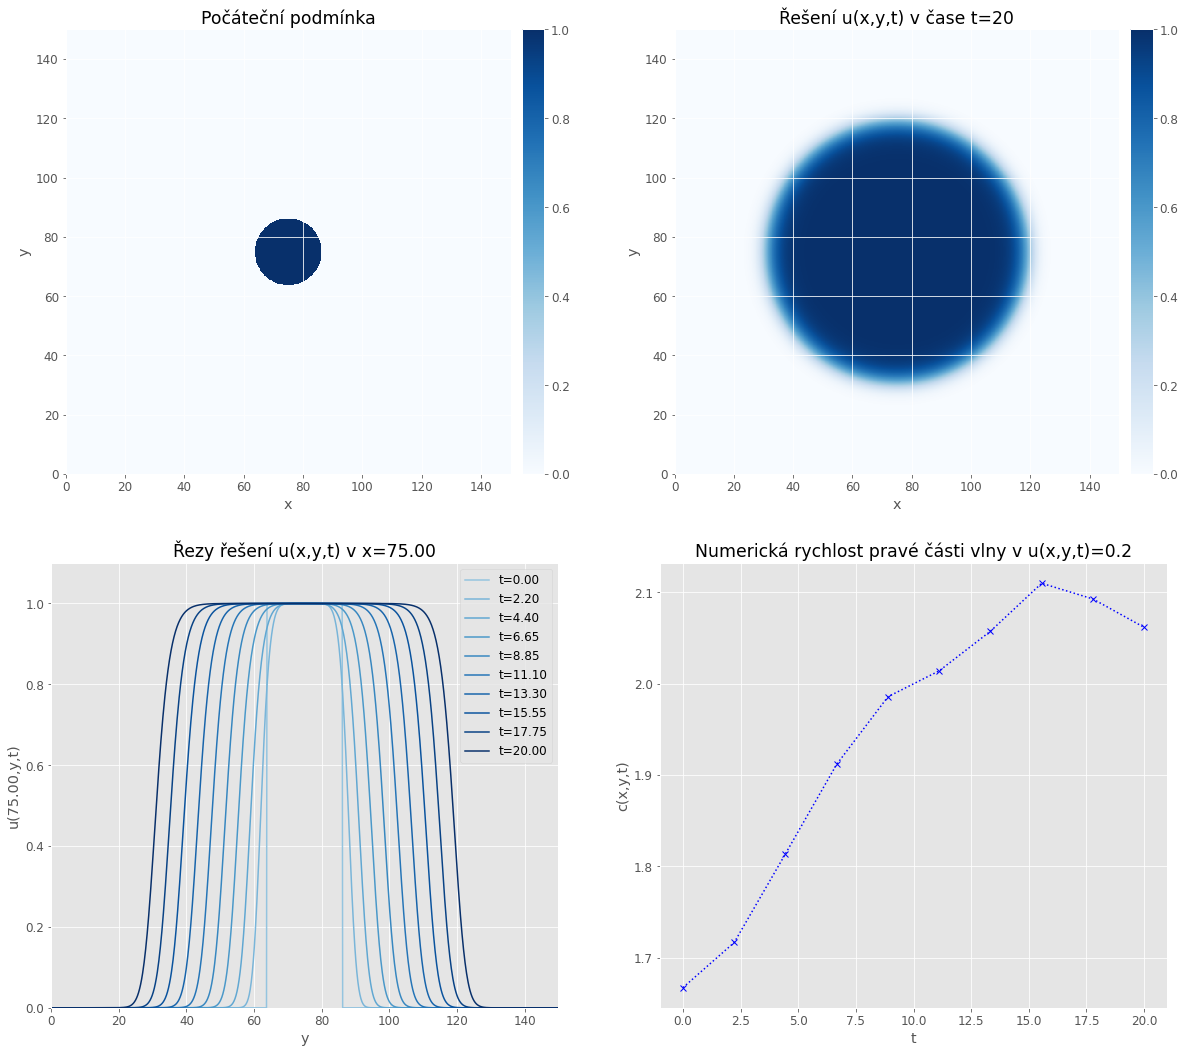

In [68]:
#bump function, size 120, size 1
result, storage, grid = fksolve(iv_size=151,
                         iv_func=lambda x,y: 1, #np.exp(1)*np.exp(-1/(1-x**2-y**2)),
                         domain_size=150,
                         max_time=20,
                         #tracker_int = .1,
                         #dt=.001,
                         grid_size=1000
                         )

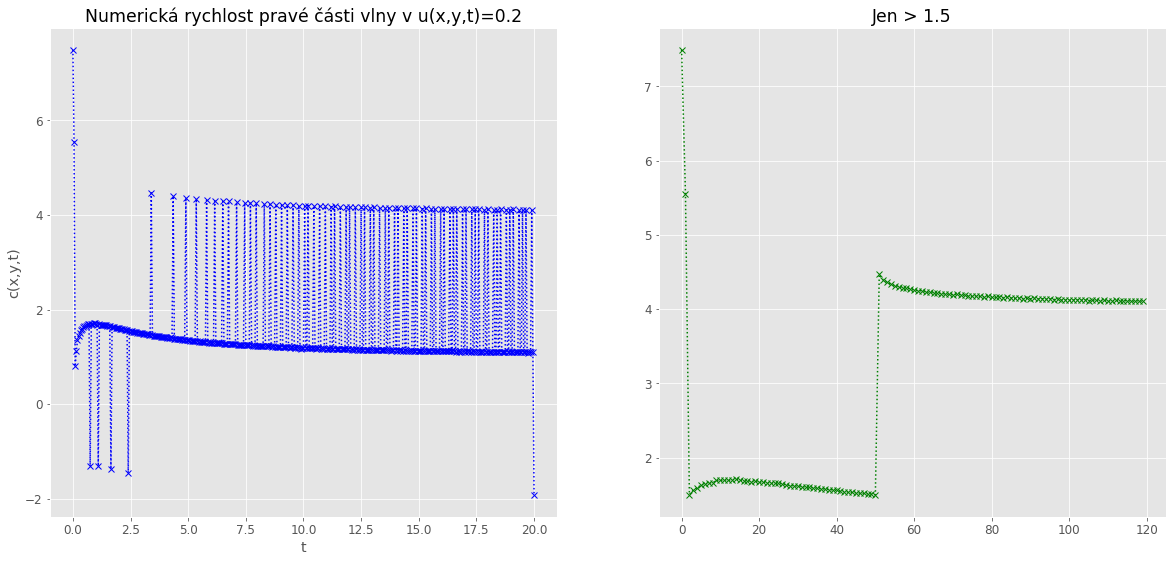

In [69]:
plt_res(storage, grid, 20, .2)

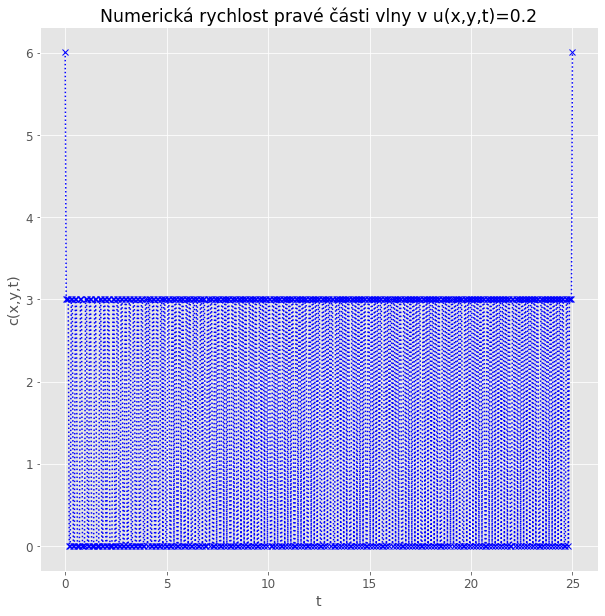

In [50]:
# c(r) speed
slice_num = 500
grid_size = 500
u_level = .2
max_time = 25

ts = np.linspace(0, len(storage.data)-1, slice_num)
ts = ts.astype(int)
t_size = len(ts)
rs = np.linspace(*grid.axes_bounds[0], grid.shape[0])

half_grid_size = int(grid_size/2)

r_t = np.zeros(t_size)

for t in range(t_size):
    r_data = storage.data[ts[t]][half_grid_size]
    #r_t[t] = np.argwhere(r_data>u_level)[-1][0] * (domain_size/grid_size)
    r_t[t] = rs[np.argwhere(r_data>=u_level)[-1]]
x = np.linspace(0, max_time, len(r_t))


plt.plot(x, np.gradient(r_t)/(max_time/t_size), 'bx:')
plt.xlabel('t')
plt.ylabel('c(x,y,t)')
plt.title('Numerická rychlost pravé části vlny v u(x,y,t)={}'.format(u_level))

plt.show()

In [47]:
len(storage.data[0])

500

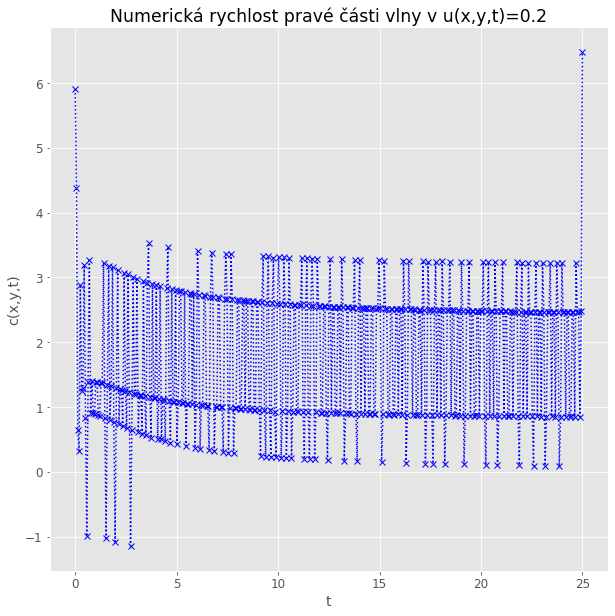

In [44]:



# c(r) speed
slice_num = 395
grid_size = 1000
u_level = .2
max_time = 25

ts = np.linspace(0, len(storage.data)-1, slice_num)
ts = ts.astype(int)
t_size = len(ts)
rs = np.linspace(*grid.axes_bounds[0], grid.shape[0])

half_grid_size = int(grid_size/2)

r_t = np.zeros(t_size)

for t in range(t_size):
    r_data = storage.data[ts[t]][half_grid_size]
    rs_inx = np.argwhere(r_data>=u_level)
    r_t[t] = rs[rs_inx[-1]] + (rs[rs_inx[-1]+1] - rs[rs_inx[-1]]) * ((u_level - r_data[rs_inx[-1]+1])/(r_data[rs_inx[-1]] - r_data[rs_inx[-1]+1])) 
x = np.linspace(0, max_time, len(r_t))


plt.plot(x, np.gradient(r_t)/(max_time/t_size), 'bx:')
plt.xlabel('t')
plt.ylabel('c(x,y,t)')
plt.title('Numerická rychlost pravé části vlny v u(x,y,t)={}'.format(u_level))

plt.show()

### Skoková funkce

Co se stane, pokud použijeme nehladkou funkci? Z následujícího experimentu je vidět, že nic zásadního. Stejně jako v případě bump funkce se funkce díky diffuznímu členu okamžitě vyhladí a začne růst až k hodnotě $1$. Rychlost opět stoupá a blíží se hodnotě $c=2.$

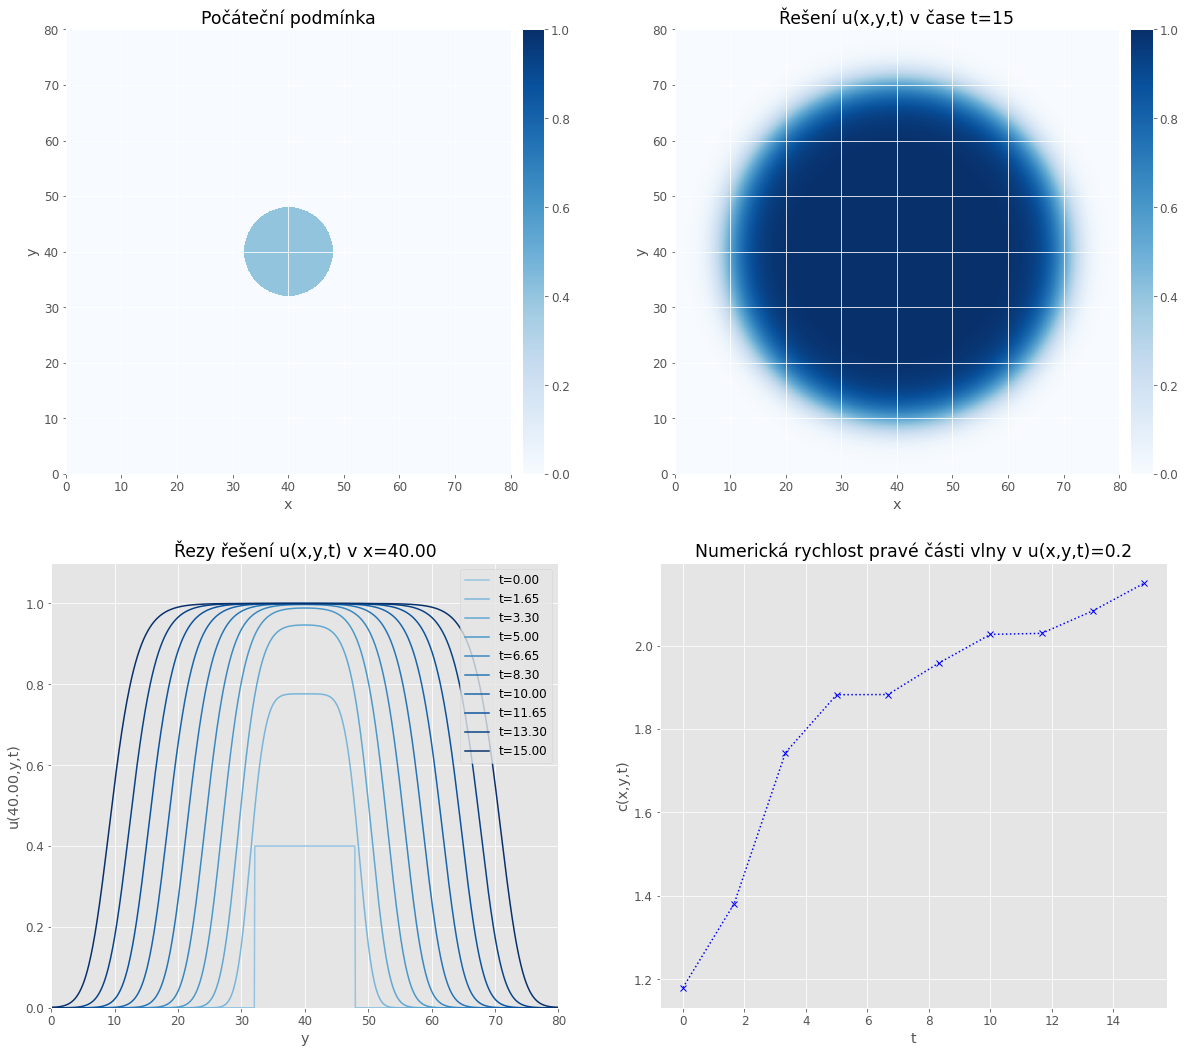

In [78]:
result, storage, grid = fksolve(iv_func = lambda x,y: .4,
                 max_time = 15,
                 domain_size = 80,
                 #grid_size = 500
               )

In [86]:
np.array(storage.times)[1:]- np.array(storage.times[:-1])

array([0.05 , 0.05 , 0.051, 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 ,
       0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 ,
       0.05 , 0.049, 0.051, 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 ,
       0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 ,
       0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 ,
       0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 ,
       0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 ,
       0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 ,
       0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 ,
       0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.049, 0.05 ,
       0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 ,
       0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 ,
       0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 ,
       0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 ,
       0.05 , 0.05 ,

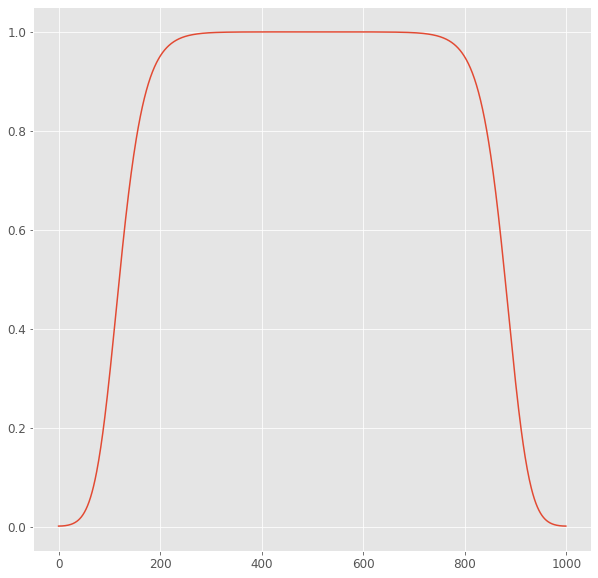

In [90]:
plt.plot(np.array(storage.data[300][500]))

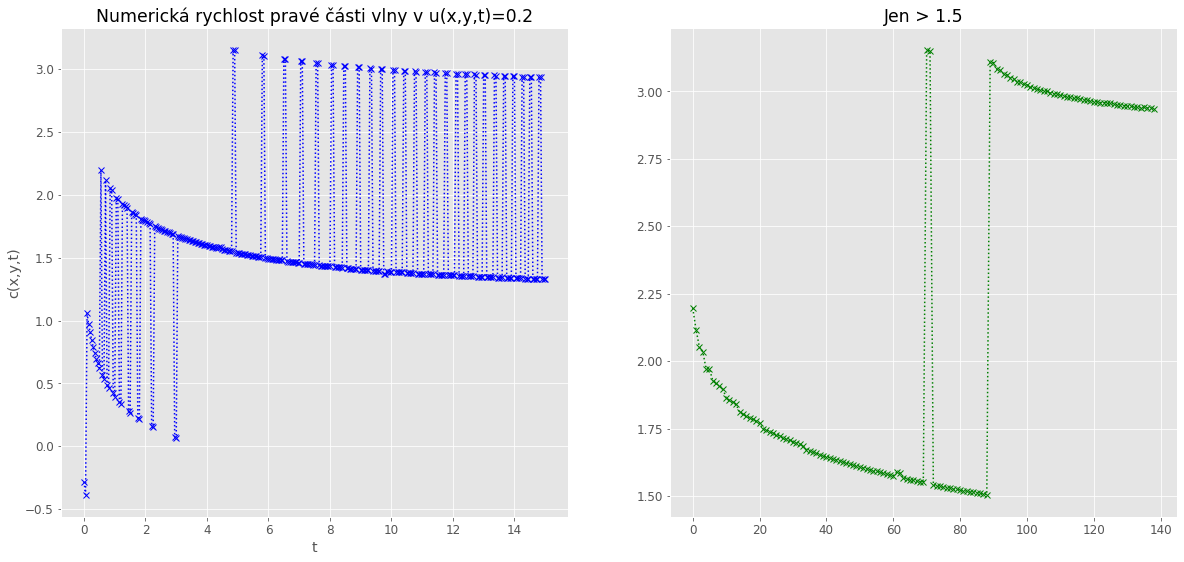

In [79]:
plt_res(storage, grid, 15, .2)

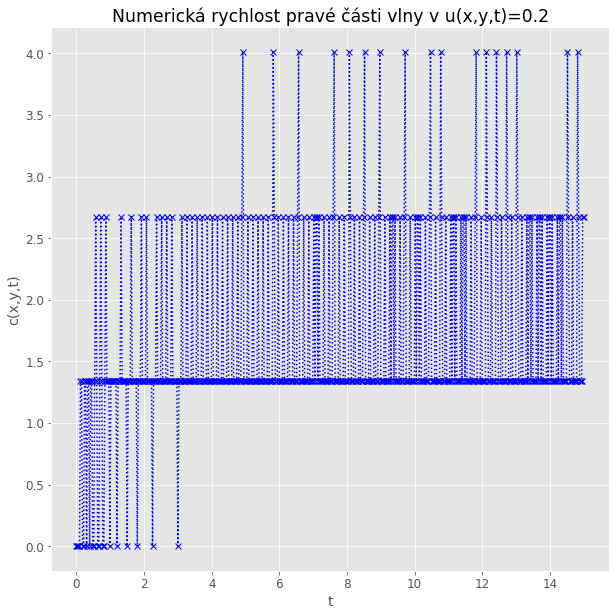

In [58]:
# c(r) speed
slice_num = 501
grid_size = 1000
u_level = .2
max_time = 15

ts = np.linspace(0, len(storage.data)-1, slice_num)
ts = ts.astype(int)
t_size = len(ts)
rs = np.linspace(*grid.axes_bounds[0], grid.shape[0])

half_grid_size = int(grid_size/2)

r_t = np.zeros(t_size)

for t in range(t_size):
    r_data = storage.data[ts[t]][half_grid_size]
    #r_t[t] = np.argwhere(r_data>u_level)[-1][0] * (domain_size/grid_size)
    r_t[t] = rs[np.argwhere(r_data>=u_level)[-1]]
x = np.linspace(0, max_time, len(r_t))


plt.plot(x, np.gradient(r_t)/(max_time/t_size), 'bx:')
plt.xlabel('t')
plt.ylabel('c(x,y,t)')
plt.title('Numerická rychlost pravé části vlny v u(x,y,t)={}'.format(u_level))

plt.show()

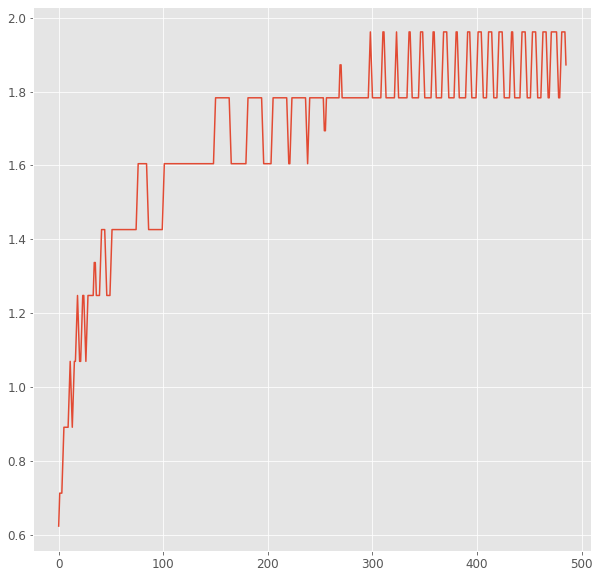

In [79]:
ccc = np.gradient(r_t)/(max_time/t_size)
#print(ccc)

pr = 15

c = np.zeros(len(ccc)-pr)
for i in range(len(ccc)-pr):

    for j in range(pr):
        c[i] += ccc[i+j]#(ccc[i]+ccc[i+1]+ccc[i+2]+ccc[i+3]+ccc[i+4]+ccc[i+5]+ccc[i+6]+ccc[i+7]+ccc[i+8]+ccc[i+9])/10
    
    c[i] = c[i]/pr
    
plt.plot(c)

### Skoková funkce s velmi malým poloměrem

Pokud je počáteční $r$ velmi malé, advekční člen nejprve sníží hodnotu funkce, převládne difuzní člen. Teprve s dostatečně velkým $r$ začne $u$ znovu růst. Rychlost šíření vlny $c$ je nejprve velmi vysoká, kvůli převládajícímu difuznímu členu, sníží se ve chvíli, kdy převládá evoluční člen a nakonec se opět pomalu ustálí na hodnotě $c\approx 2$.

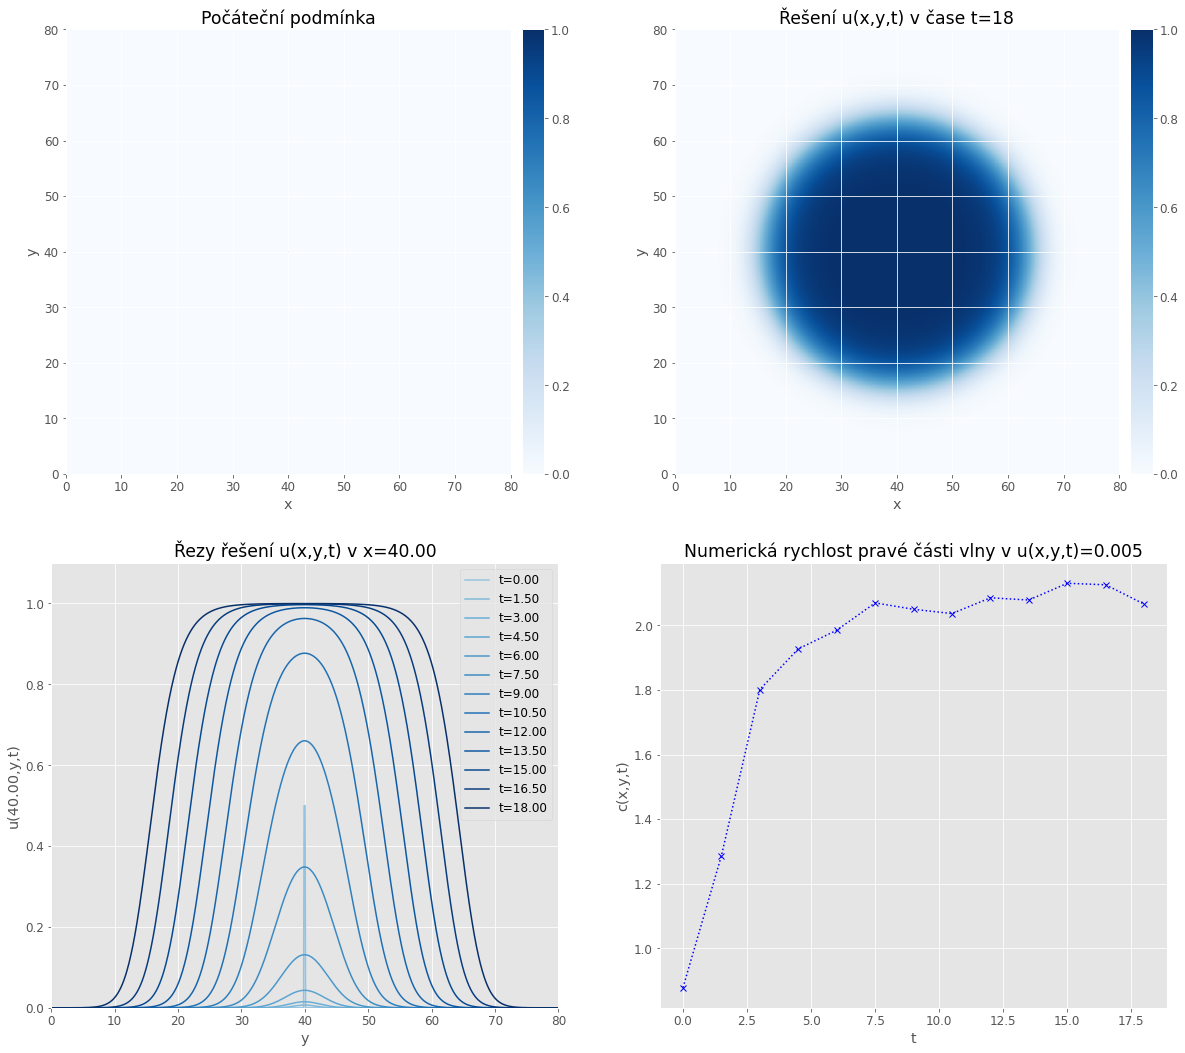

In [81]:
result, storage, grid = fksolve(iv_func= lambda x,y: .5, 
                                iv_size=5, 
                                max_time=18, 
                                u_level=0.005,
                               slice_num = 13,
                               domain_size = 80,
                               #grid_size = 1500
                               )

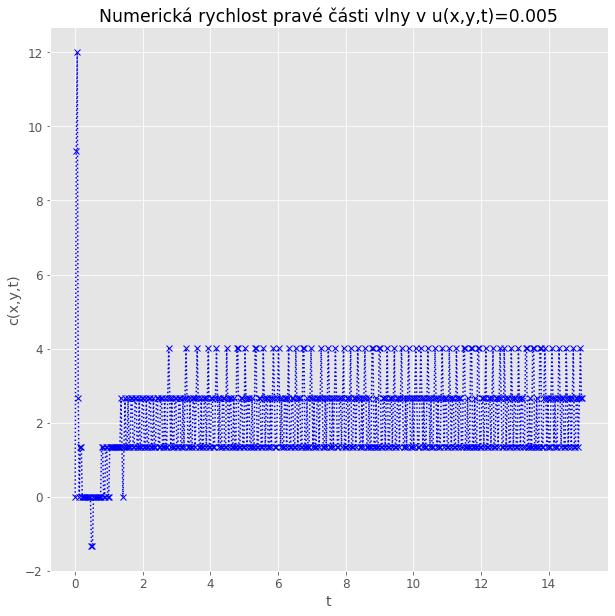

In [86]:
# c(r) speed
slice_num = 500
grid_size = 1000
u_level = .005
max_time = 15

ts = np.linspace(0, len(storage.data)-1, slice_num)
ts = ts.astype(int)
t_size = len(ts)
rs = np.linspace(*grid.axes_bounds[0], grid.shape[0])

half_grid_size = int(grid_size/2)

r_t = np.zeros(t_size)

for t in range(t_size):
    r_data = storage.data[ts[t]][half_grid_size]
    #r_t[t] = np.argwhere(r_data>u_level)[-1][0] * (domain_size/grid_size)
    r_t[t] = rs[np.argwhere(r_data>=u_level)[-1]]
x = np.linspace(0, max_time, len(r_t))


plt.plot(x, np.gradient(r_t)/(max_time/t_size), 'bx:')
plt.xlabel('t')
plt.ylabel('c(x,y,t)')
plt.title('Numerická rychlost pravé části vlny v u(x,y,t)={}'.format(u_level))

plt.show()

### Skoková funkce s maximem větším než 1

Pokud bude počáteční podmínka mít větší hodnotu než 1, evoluční člen $u(1-u)$ funkci "stáhne" k hodnotě $1$. Stejně jako v předchozím případě se počáteční velmi vysoká rychlost vlny (kvůli vyhlazení difuzí) nejprve sníží a později se přibližuje k hodnotě $c\approx2$.

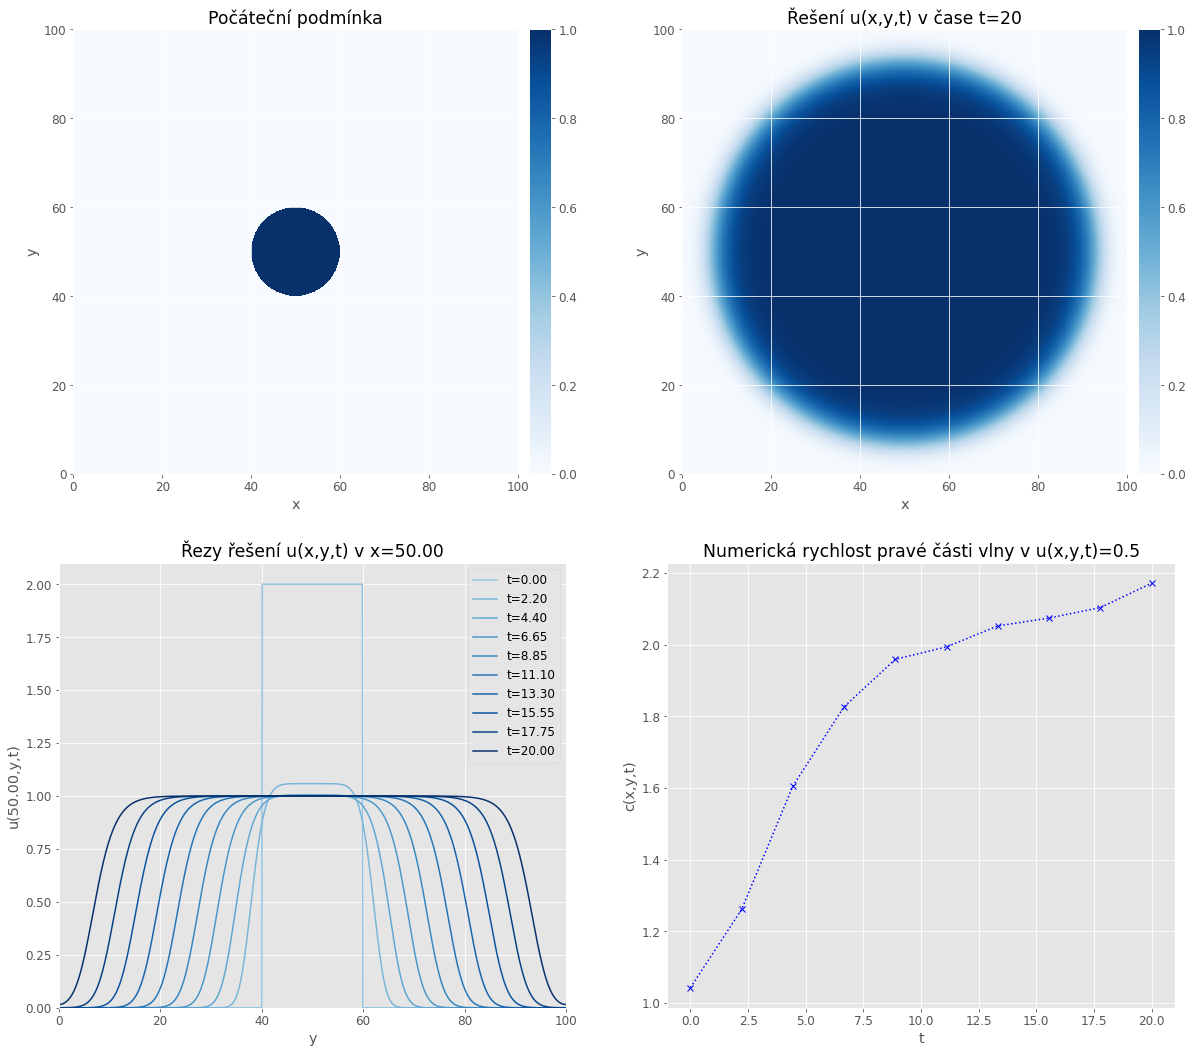

In [95]:
result, storage, grid = fksolve(iv_func= lambda x,y: 2,
                               ylim=2.1,
                               u_level = .5,
                               max_time = 20,
                               #grid_size = 1000
                               )

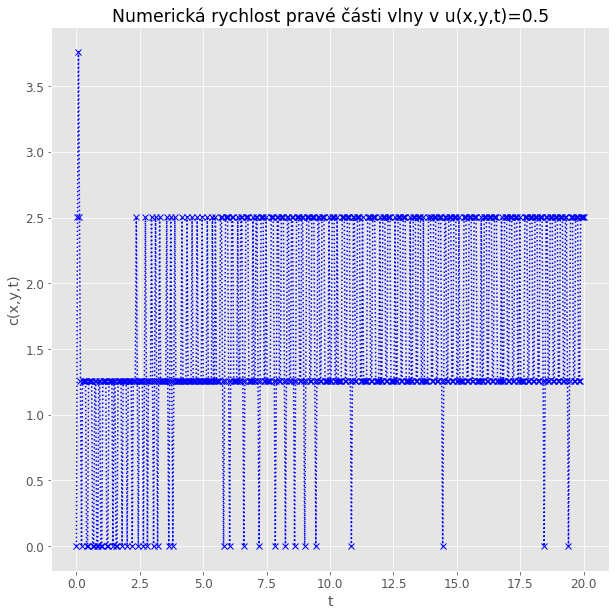

In [99]:
# c(r) speed
slice_num = 501
grid_size = 1000
u_level = .5
max_time = 20

ts = np.linspace(0, len(storage.data)-1, slice_num)
ts = ts.astype(int)
t_size = len(ts)
rs = np.linspace(*grid.axes_bounds[0], grid.shape[0])

half_grid_size = int(grid_size/2)

r_t = np.zeros(t_size)

for t in range(t_size):
    r_data = storage.data[ts[t]][half_grid_size]
    #r_t[t] = np.argwhere(r_data>u_level)[-1][0] * (domain_size/grid_size)
    r_t[t] = rs[np.argwhere(r_data>=u_level)[-1]]
x = np.linspace(0, max_time, len(r_t))


plt.plot(x, np.gradient(r_t)/(max_time/t_size), 'bx:')
plt.xlabel('t')
plt.ylabel('c(x,y,t)')
plt.title('Numerická rychlost pravé části vlny v u(x,y,t)={}'.format(u_level))

plt.show()

### Bump funkce s lokální perturbací

Ukažme si, co se stane, pokud na počáteční bump funkci aplikujeme nějakou lokální perturbaci. 

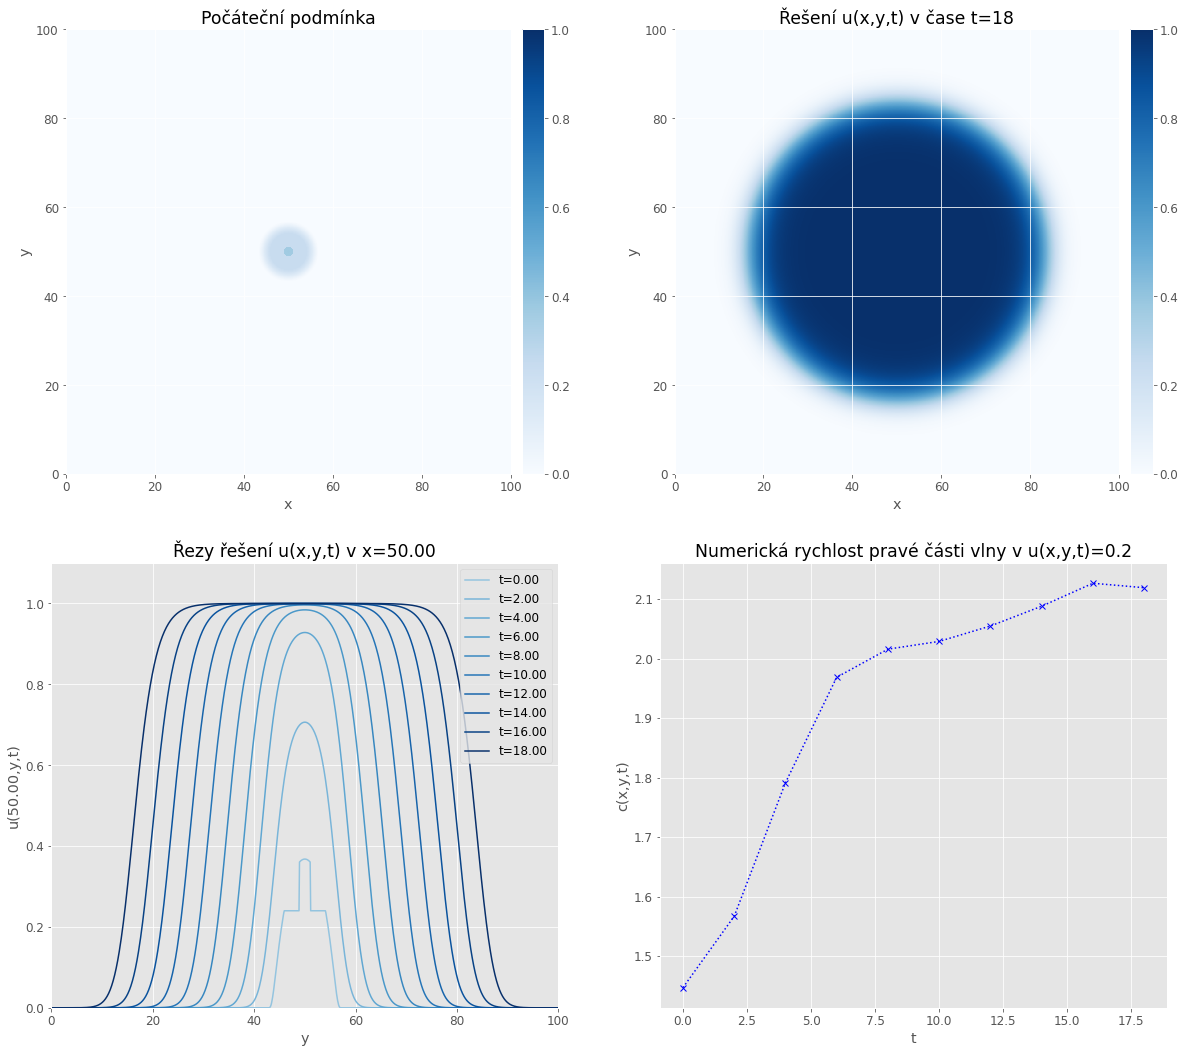

In [100]:
#bump function s perturbací
def ivs(x,y):
    c = x**2+y**2
    #print(c)
    if .02 < c < .3:
        return .24
    else:
        return np.exp(-1/(1-x**2-y**2))


result, storage, grid = fksolve(max_time=18, 
                                iv_func=ivs, 
                                iv_size=150)


### Bump funkce s radiálně nesymetrickou perturbací

Jen pro zajímavost si ukažme případ, kdy počáteční podmínka nebude radiálně sysmetrická.

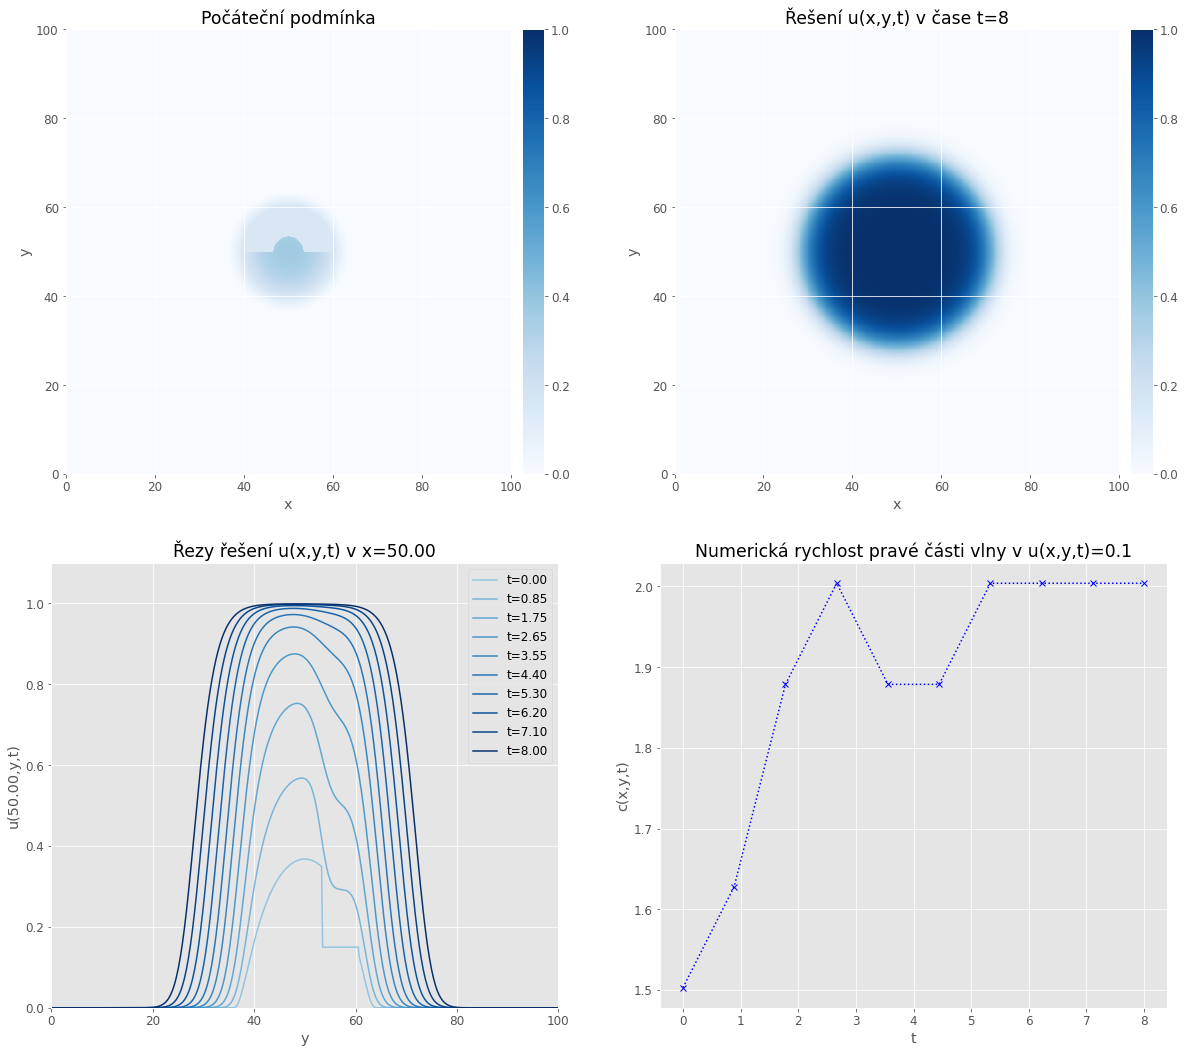

In [6]:
# zkusit totéž co v předchozím případě, ale jen na výseči, podmínka nebude radiálně symetrická
# do podmínky přidat ještě podmínku že x a y jsou kladné

#bump function s NESYMETRICKOU perturbací
def ivs(x,y):
    c = x**2+y**2
    #print(c)
    if (.05 < c < .5) and (y > 0):
        return .15
    else:
        return np.exp(-1/(1-x**2-y**2))


result, storage, grid = fksolve(max_time=8, 
                                iv_func=ivs, 
                                iv_size=150,
                                u_level = .1)

#plt.imshow(np.rot90(storage.data[0]), cmap='Blues', clim=(0,1))
#plt.title('Počáteční podmínka')
#plt.xlabel('x')
#plt.ylabel('y')
#plt.colorbar()
#plt.show()